# Two samplers for probabilistic programming: PyStan and Emcee

## I. PyStan

Let's begin by generating some data. The idea of this example is to build a linear regression model with two predictor variables and one predicted value. In equations:

$$
Z_{\text{n}} = \alpha + \beta_{\text{x}} x_{\text{n}} + \beta_y y_{\text{n}} + \epsilon 
$$

where $ \epsilon $ represents Gaussian noise. 

As usual, we first import some needed libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from numpy import *
# The actual library that is one of the reasons of this notebook... PySTAN
import pystan

We generate some artificial data...

In [2]:
# Number of observations:
Nobs = 20
# Values for X and Y predictors
x_true = random.uniform(0,10, size=Nobs)
y_true = random.uniform(-1,1, size=Nobs)
# Parameters of the model...
alpha_true = 0.5
beta_x_true = 1.0
beta_y_true = 10.0
# Parameter for Gaussian noise...
eps_true = 0.5
# Actual value ...
z_true = alpha_true + beta_x_true*x_true + beta_y_true*y_true
# Data generated; actual value plus Gaussian noise
z_obs = z_true + random.normal(0, eps_true, size=Nobs)

... and now we plot them

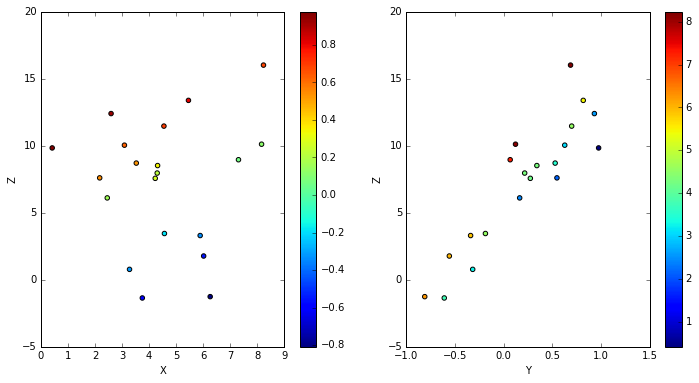

In [3]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x_true, z_obs, c=y_true, marker='o')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.subplot(1,2,2)
plt.scatter(y_true, z_obs, c=x_true, marker='o')
plt.colorbar()
plt.xlabel('Y')
plt.ylabel('Z')

We now write the actual STAN model:

In [4]:
model = """
data {
   int<lower=4> N; // Number of data points
   real x[N];      // the 1st predictor
   real y[N];      // the 2nd predictor
   real z[N];      // the outcome
}
parameters {
   real alpha;     // intercept
   real betax;     // x-slope
   real betay;     // y-slope
   real<lower=0> eps;       // dispersion
}
model {
   for (i in 1:N)
      z[i] ~ normal(alpha + betax * x[i] + betay * y[i], eps);
}"""

PyStan requires us to set the data in the form of a dictionary where key is the variable and value are the data corresponding to such variable; like so:

In [5]:
data = {'N':Nobs, 'x':x_true, 'y':y_true, 'z':z_obs}

We can now fit the data:

In [6]:
fit = pystan.stan(model_code = model, data = data, iter=1000, chains=4)

The above line of code gives Stan the model string and the data. We have requested 1000 MCMC iterations each run on 4 parallel chains. The first time we fit a model, PyStan converts the STAN model into C++ code (making it fast), so it may take a while to start up. Once it is finished we can get a summary of the results:

In [7]:
print fit

Inference for Stan model: anon_model_a87850813aab96ee1be5112f40cf12e0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.64    0.02   0.35  -0.03   0.41   0.63   0.87   1.35  418.0    1.0
betax   1.03  3.4e-3   0.07   0.89   0.98   1.03   1.07   1.16  408.0    1.0
betay   9.48    0.01   0.26   8.93   9.31   9.49   9.66   9.98  496.0    1.0
eps     0.59  4.8e-3    0.1   0.42   0.51   0.57   0.64   0.84  463.0    1.0
lp__    1.11    0.07   1.45  -2.45    0.4   1.45   2.16   2.97  382.0   1.01

Samples were drawn using NUTS at Wed Oct  5 11:15:23 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


We can also plot out the chains and posterior probability distributions.

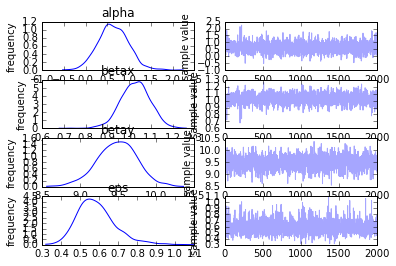

In [8]:
p = fit.plot()

We now can run the MCMC sample with a larger number of iterations. This time should take less time as the model has already been set up. Let's do this time, say, 10000 iterations.

In [9]:
fit2 = pystan.stan(fit=fit, data=data, iter=10000, chains=4)

In [10]:
fit2

Inference for Stan model: anon_model_a87850813aab96ee1be5112f40cf12e0.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   0.64  5.6e-3   0.36  -0.08   0.41   0.63   0.87   1.35 4169.0    1.0
betax   1.03  1.1e-3   0.07   0.89   0.98   1.03   1.07   1.17 4262.0    1.0
betay   9.48  3.7e-3   0.26   8.96   9.31   9.49   9.66  10.01 5033.0    1.0
eps     0.59  1.6e-3   0.11   0.42   0.51   0.57   0.64   0.84 4509.0    1.0
lp__    1.07    0.02   1.51  -2.83   0.32   1.41   2.17   2.95 3944.0    1.0

Samples were drawn using NUTS at Wed Oct  5 11:17:36 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

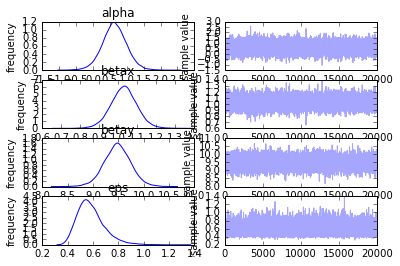

In [11]:
temp = fit2.plot()

Let's now get the median of each variable from the samples. There are two ways to extract the chains. We can set 

1) permuted=True to get a dictionary with each key corresponding to a parameter.

or

2) permuted=False, which returns a 3D array with indeces (i,c,p), corresponding to iteration i in chain c for parameter p.

For this example let's use permuted = True

In [12]:
samples = fit2.extract(permuted=True)
alpha = median(samples['alpha'])
beta_x = median(samples['betax'])
beta_y = median(samples['betay'])
eps = median(samples['eps'])

We have opted for exploring the median as it is a parameter more robust, particularly for skewed distributions, such as the one for *epsilon*. Now we can plot the results, this time correcting for the y predictor when plotting versus x and vice versa. That way we can make sure the correct trend has been found. We can also plot a shaded region denoting the intrinsic dispersion.

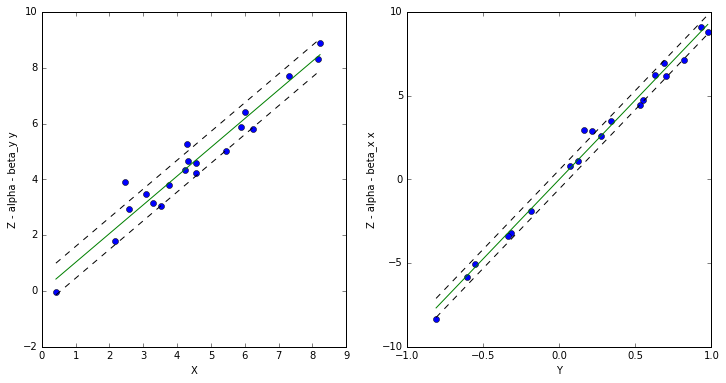

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x_true, z_obs-alpha-beta_y*y_true, 'o')
plt.xlabel('X')
plt.ylabel('Z - alpha - beta_y y')
# Now plot the model
xx = array([x_true.min(), x_true.max()])
plt.plot(xx, xx*beta_x)
plt.plot(xx, xx*beta_x + eps, '--', color='k')
plt.plot(xx, xx*beta_x - eps, '--', color='k')
plt.subplot(1,2,2)
plt.plot(y_true, z_obs-alpha-beta_x*x_true, 'o')
plt.xlabel('Y')
plt.ylabel('Z - alpha - beta_x x')
yy = array([y_true.min(), y_true.max()])
plt.plot(yy, yy*beta_y)
plt.plot(yy, yy*beta_y + eps, '--', color='k')
plt.plot(yy, yy*beta_y - eps, '--', color='k')

## II. Emcee

We will use the same data we generated for the PyStan example. So we now proceed to import Emcee

In [21]:
import emcee

A big difference between emcee and PyStan is that the module is all about the sampler and does not provide any build-in distributions; one has to write the entire probability function oneself. Following the example on emcee's site, we do this by writing log-prior, log-likelihood, and log-probability functions:

In [22]:
# Log-prior
def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
    alpha,betax,betay,eps = p
    # We're using only uniform priors, and only eps has a lower bound
    if eps <= 0:
        return -inf
    return 0

# Log-likelihood
def lnlike(p, x, y, z):
    alpha,betax,betay,eps = p
    model = alpha + betax*x + betay*y
    # the likelihood is sum of the log of normal distributions
    denom = power(eps,2)
    lp = -0.5*sum(power((z - model),2)/denom + log(denom) + log(2*pi))
    return lp

# Log-probability
def lnprob(p, x, y, z):
    lp = lnprior(p)
    if not isfinite(lp):
        return -inf
    return lp + lnlike(p, x, y, z)
   

The total probability $ p\left(\theta|D\right) $ is given by lnprob. One can think of the model as getting more complicated and hierarchical; the coding would be much more complicated than with PyStan. Now, the pymc documentation recommends finding the maximum likelihood using scipy's optimize module:

In [46]:
import scipy.optimize as opt
nll = lambda *args: -lnlike(*args)
result = opt.minimize(nll, [alpha_true, beta_x_true, beta_y_true, eps_true],
                      args=(x_true, y_true, z_obs))
print result['x']

[ 0.63919534  1.02896181  9.47817994  0.49956438]


Now that we have the maximum likelihood, we must create a number of walkers to sample our parameters space and instantiate each with a slightly different starting point.

In [47]:
Nwalker,Ndim = 50,4
p0 = [result['x']+1.e-4*random.randn(Ndim) for i in range(Nwalker)]

We feed the lnprob and the initial staring points of the Nwalker walkers to the ensemble sampler and let it run. Multiprocessing is built in, so one can take advantage of multiple CPU's to run the walkers in parallel.


In [50]:
sampler = emcee.EnsembleSampler(Nwalker,Ndim,lnprob,
                                args=(x_true,y_true,z_obs))
pos,prob,state = sampler.run_mcmc(p0, 500)

The sampler will now have a *chain* attribute which is an array with shape $ (Nwalker,N,Ndim) $ where $ N $ is the number of interations (500 in our inital run). We can plot these traces out to see what is going on. We will focus on $ \alpha $

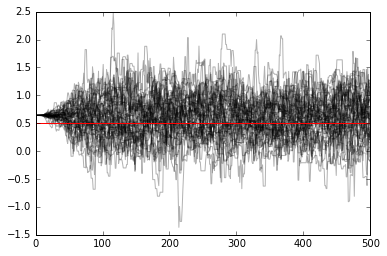

In [52]:
res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
plt.axhline(alpha_true, color='red')

The walkers start out bundled together. Then they start to explore the parameter space and finally converge on a fixed dispersion around a value close to the true value (in red). We can run the sampler for longer. To do this, we reset the sampler (to get rid of the previous chain) and start where the sampler left off (pos).

In [53]:
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, 1000)

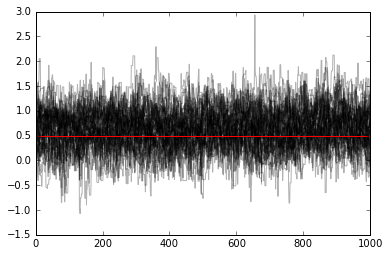

In [54]:
res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
plt.axhline(alpha_true, color='red')

As well as *chain*, the sampler has a *flatchain* attribute which simply concatenates all the walkers' chains into one. So the array shape will be $ (N, Ndim) $. We compute the medians and plot the results of the model.

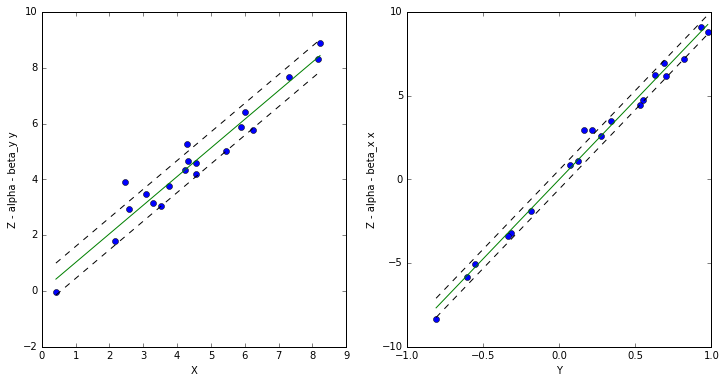

In [55]:
m_alpha,m_betax,m_betay,m_eps = median(sampler.flatchain, axis=0)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x_true, z_obs-m_alpha-m_betay*y_true, 'o')
plt.xlabel('X')
plt.ylabel('Z - alpha - beta_y y')
# Now plot the model
xx = array([x_true.min(), x_true.max()])
plt.plot(xx, xx*m_betax)
plt.plot(xx, xx*m_betax + m_eps, '--', color='k')
plt.plot(xx, xx*m_betax - m_eps, '--', color='k')
plt.subplot(1,2,2)
plt.plot(y_true, z_obs-m_alpha-m_betax*x_true, 'o')
plt.xlabel('Y')
plt.ylabel('Z - alpha - beta_x x')
yy = array([y_true.min(), y_true.max()])
plt.plot(yy, yy*m_betay)
plt.plot(yy, yy*m_betay + m_eps, '--', color='k')
plt.plot(yy, yy*m_betay - m_eps, '--', color='k')

We finally make use of the *corner* Python library, http://corner.readthedocs.io/en/latest/index.html#

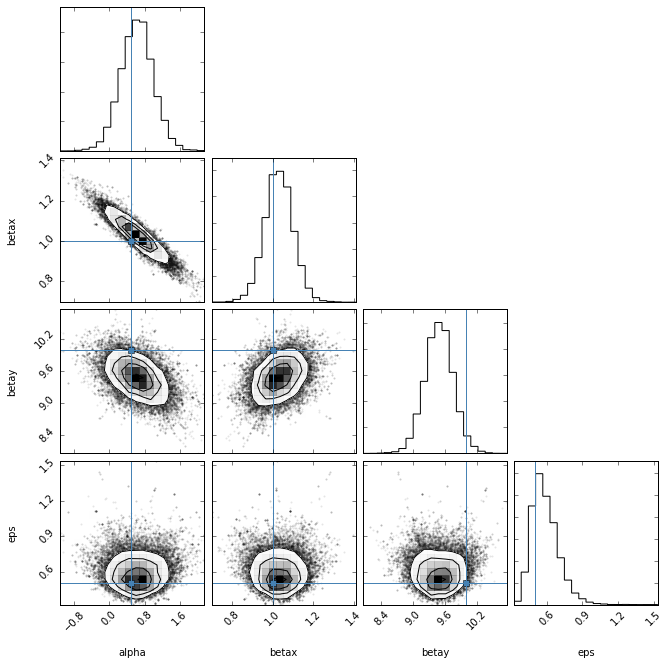

In [37]:
import corner
tmp = corner.corner(sampler.flatchain, labels=['alpha','betax','betay','eps'], 
                truths=[alpha_true, beta_x_true, beta_y_true, eps_true])


The corner plot shows all the one and two dimensional projections of the posterior probability distributions of the parameters. This is useful because it quickly demonstrates all of the covariances between parameters. Also, the way that one finds the marginalized distribution for a parameter or set of parameters using the results of the MCMC chain is to project the samples into that plane and then make an N-dimensional histogram. That means that the corner plot shows the marginalized distribution for each parameter independently in the histograms along the diagonal and then the marginalized two dimensional distributions in the other panels.